<a href="https://colab.research.google.com/github/Jhancyamarsingh17/Automated-medical-report-generation-and-classification-/blob/main/EDA_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libararies

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import regex as re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Read Data

In [5]:
report_df= pd.read_csv('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/indiana_reports.csv')
report_df

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
...,...,...,...,...,...,...,...,...
3846,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...
3847,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...
3848,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB."
3849,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.


In [6]:
proj_df= pd.read_csv('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/indiana_projections.csv')
proj_df

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal
...,...,...,...
7461,3997,3997_IM-2048-1002.dcm.png,Lateral
7462,3998,3998_IM-2048-1001.dcm.png,Frontal
7463,3998,3998_IM-2048-1002.dcm.png,Lateral
7464,3999,3999_IM-2049-1001.dcm.png,Frontal


# Data Wrangling

## Check NULL values and Impute in  dataframe.

In [8]:
#Check for Null values in Text columns
NaN = report_df.isnull().sum()
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in comparison columns -",NaN[2])
print("Total Nan Values in Indication columns -",NaN[3])
print("Total Nan Values in findings columns   -",NaN[4])
print("Total Nan Values in Impression columns -",NaN[5])

Total Nan Values in caption columns - 0
Total Nan Values in comparison columns - 0
Total Nan Values in Indication columns - 0
Total Nan Values in findings columns   - 86
Total Nan Values in Impression columns - 599


In [10]:
#Replacing the nan values
report_df['image'] = report_df['image'].fillna('Unknown')
report_df['comparison'] = report_df['comparison'].fillna('No Comparison')
report_df['indication'] = report_df['indication'].fillna('No Indication')
report_df['findings'] = report_df['findings'].fillna('No Findings')
report_df['impression'] = report_df['impression'].fillna('No Impression')

In [24]:
NaN_1 = proj_df.isnull().sum()
NaN_1

uid           0
filename      0
projection    0
dtype: int64

## Data Cleaning

In [25]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
def decontraction(doc):
    docs = re.sub(r"won't", "will not", doc)
    docs = re.sub(r"can\'t", "can not", docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have", docs)
    docs = re.sub(r"\'m", " am",docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have",docs)
    docs = re.sub(r"\'m", " am", docs)
    docs = re.sub(r"\*+", "abuse", docs)
    return docs

def remove_stopwords(data):
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')# removing the "not" from the stopwords
  all_stopwords.remove('no')
  text_tokens = word_tokenize(data) # tokenizing the sentence into word
  tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
  return " ".join(tokens_without_sw)

def text_preprocess(data):
  clean_text=[]
  for i in (data.values):
    text = BeautifulSoup(i, 'lxml').get_text()
    text=text.lower()# making the text in lower case
    text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)# removing the special character in text
    text=re.sub(r"xxxx","",text)# Removing the irrelavent XXXX words
    text=re.sub(r'xxx',"",text)
    text=re.sub(r'xx',"",text)
    text=re.sub(r'[0-9]',"",text)# Removing the number in text
    text = re.sub(r"yearold", "", text)
    text= re.sub('\s+',' ',text)
    text=re.sub("'",'',text)# Removing apoustahe
    text=re.sub(r'\.\.+', '.',text)# Removing multiple full stop
    text=re.sub(r'  ',"",text)
    text=decontraction(text)
    text=remove_stopwords(text)
    clean_text.append(text)
  return clean_text
report_df["comparison"]=text_preprocess(report_df["comparison"]) 
report_df["image"]=text_preprocess(report_df["image"]) 
report_df["indication"]=text_preprocess(report_df["indication"])
report_df["findings"]=text_preprocess(report_df["findings"])
report_df["impression"]=text_preprocess(report_df["impression"])  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
report_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,xray chest pa lateral,positive tb test,none,cardiac silhouette mediastinum size within nor...,normal chest x
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,chest views frontal lateral,preop bariatric surgery,none,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings
2,3,normal,normal,xray chest pa lateral,rib pain steps pain r back r elbow r rib no pr...,no comparison,no findings,no displaced rib fractures pneumothorax pleura...
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...",pa lateral views chest hours,,none available,diffuse bilateral interstitial alveolar opacit...,bullous emphysema interstitial fibrosis probab...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,xray chest pa lateral,chest nasal congestion,no comparison,cardiomediastinal silhouette pulmonary vascula...,no acute cardiopulmonary abnormality


## Merge Dataframes

In [27]:

merged_df = pd.merge(proj_df, report_df, left_on="uid", right_on="uid")


In [28]:
merged_df

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,xray chest pa lateral,positive tb test,none,cardiac silhouette mediastinum size within nor...,normal chest x
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,xray chest pa lateral,positive tb test,none,cardiac silhouette mediastinum size within nor...,normal chest x
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,chest views frontal lateral,preop bariatric surgery,none,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,chest views frontal lateral,preop bariatric surgery,none,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,xray chest pa lateral,rib pain steps pain r back r elbow r rib no pr...,no comparison,no findings,no displaced rib fractures pneumothorax pleura...
...,...,...,...,...,...,...,...,...,...,...
7461,3997,3997_IM-2048-1002.dcm.png,Lateral,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,pa lateral views chest,male positive ppd,none available,heart size within normal limits small nodular ...,no acute findings no evidence active tb
7462,3998,3998_IM-2048-1001.dcm.png,Frontal,normal,normal,pa lateral chest comparison,tuberculosis positive ppd,no comparison,no findings,heart size normal lungs clear
7463,3998,3998_IM-2048-1002.dcm.png,Lateral,normal,normal,pa lateral chest comparison,tuberculosis positive ppd,no comparison,no findings,heart size normal lungs clear
7464,3999,3999_IM-2049-1001.dcm.png,Frontal,normal,normal,chest pa lateral,female patient shortness breath,chest x,no findings,cardiac silhouette normal size configuration m...


# EDA

## Analysis of Uniqueness in INIDICATION Features

Number of unique indications  in the dataset: 1943
Number of indications  repeated more than one times: 205



<BarContainer object of 1 artists>

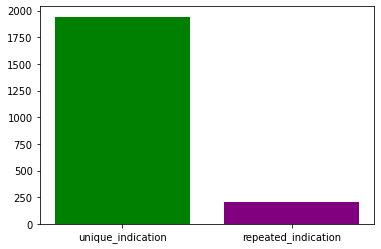

In [33]:
import matplotlib.pyplot as plt
indication_reports=pd.Series(report_df["indication"].tolist())
len_indication=len(indication_reports)
unique_indication_report=len(np.unique(indication_reports))
print("Number of unique indications  in the dataset: {}".format(unique_indication_report))
repeated_indication_report=np.sum(indication_reports.value_counts()>1)
print("Number of indications  repeated more than one times: {}".format(repeated_indication_report))
print()
plt.bar(["unique_indication"], unique_indication_report, color='green')
plt.bar(["repeated_indication"], repeated_indication_report, color='purple' )

We conclude from above indication features bar plot, total 205 are repeated indication sentences in indication feature and total 1981 words are unique indication sentences in the dataset.



## Plotting top 50 frequent sentences of INIDICATION feature

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


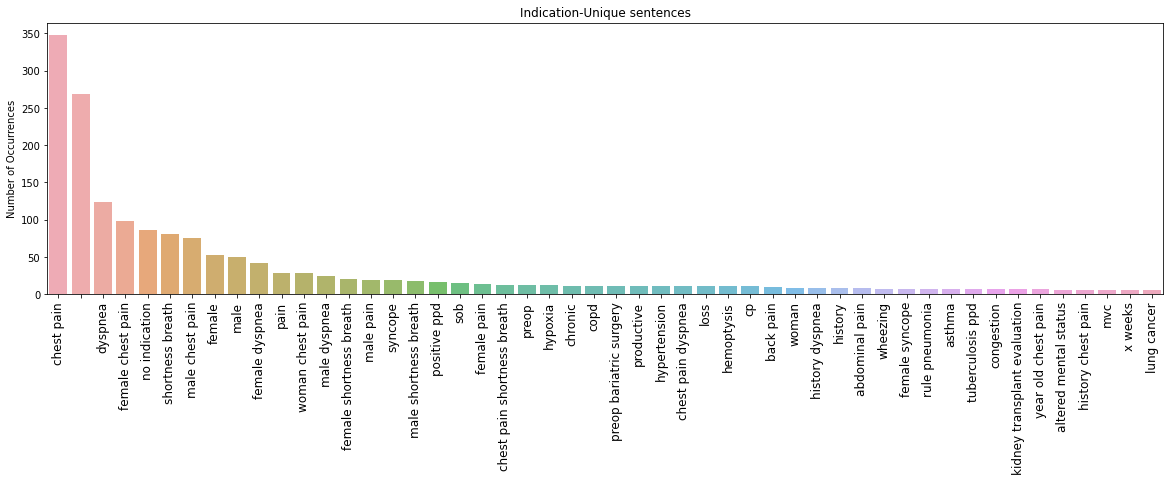

In [ ]:
import seaborn as sns

#Plotting top 50 frequent sentences of Indication feature
sentences = report_df['indication'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Indication-Unique sentences")
plt.show()

## WordCloud of INDICATION feature

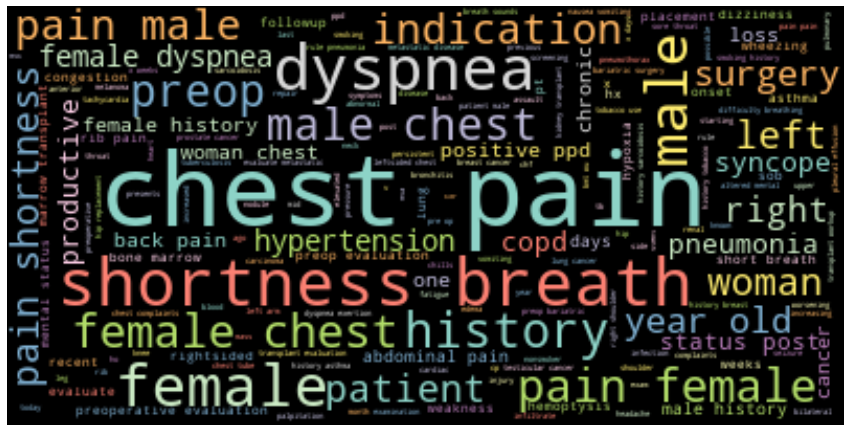

In [31]:
from wordcloud import WordCloud 

wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(report_df['indication'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

From wordcloud : chest,pain, shortness breath, indication,dyspnea are the are important words.

## Analysis of Uniqueness in FINDINGS Features

Number of unique findings report in the dataset: 2520
Number of findings repeated more than one times: 148



<BarContainer object of 1 artists>

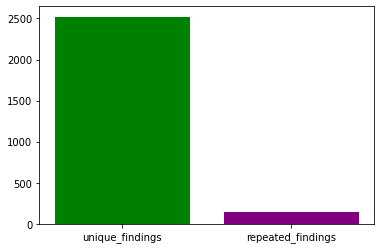

In [34]:
findings_reports=pd.Series(report_df["findings"].tolist())
len_findings=len(findings_reports)
unique_findings_report=len(np.unique(findings_reports))
print("Number of unique findings report in the dataset: {}".format(unique_findings_report))
repeated_findings_report=np.sum(findings_reports.value_counts()>1)
print("Number of findings repeated more than one times: {}".format(repeated_findings_report))
print()
plt.bar(["unique_findings"], unique_findings_report, color='green')
plt.bar(["repeated_findings"], repeated_findings_report, color='purple' )

We conclude from above findings features bar plot, total 148 are repeated findings  sentences in findings  feature and total 2520 findings sentences are unique indication sentences in the dataset.

## Plotting top 50 frequent sentences of FINDINGS feature

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


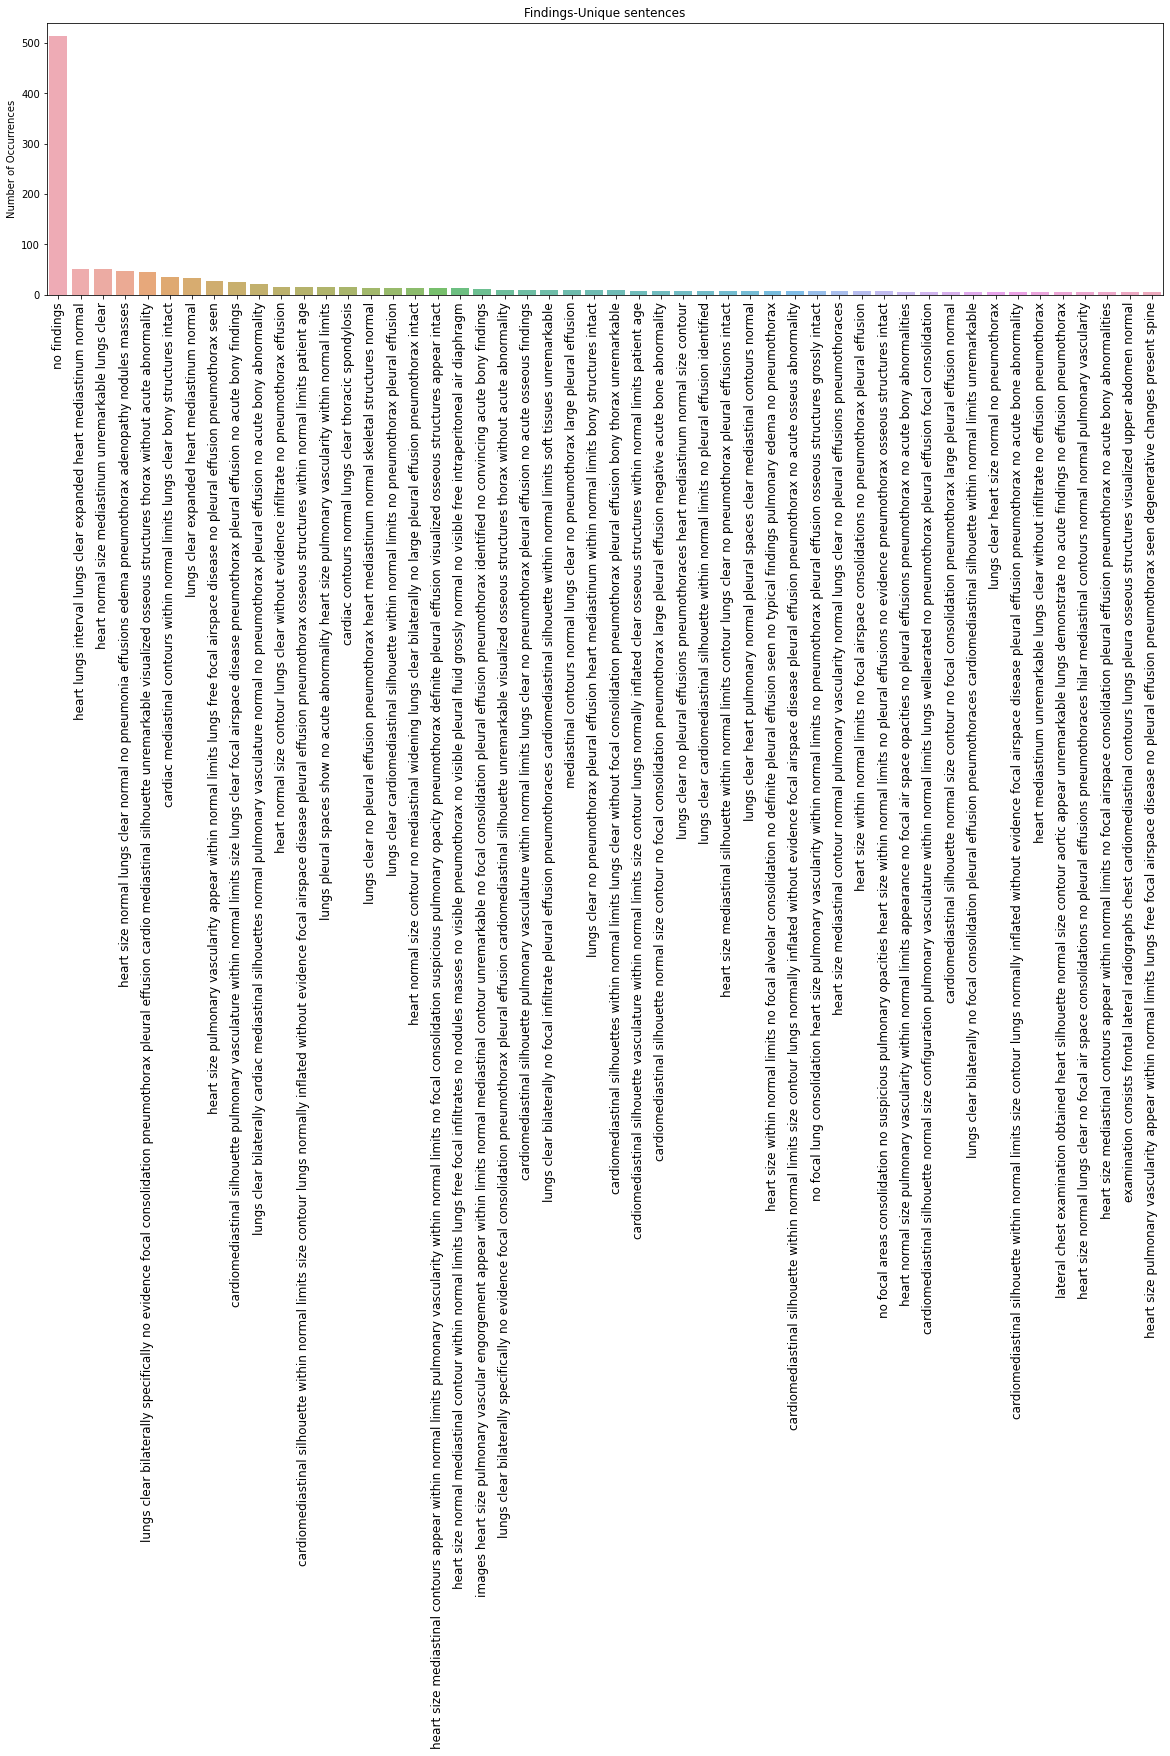

In [ ]:
#Plotting top 50 frequent sentences of Findings feature
sentences = report_df['findings'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Findings-Unique sentences")
plt.show()

## WordCloud of FINDINGS feature

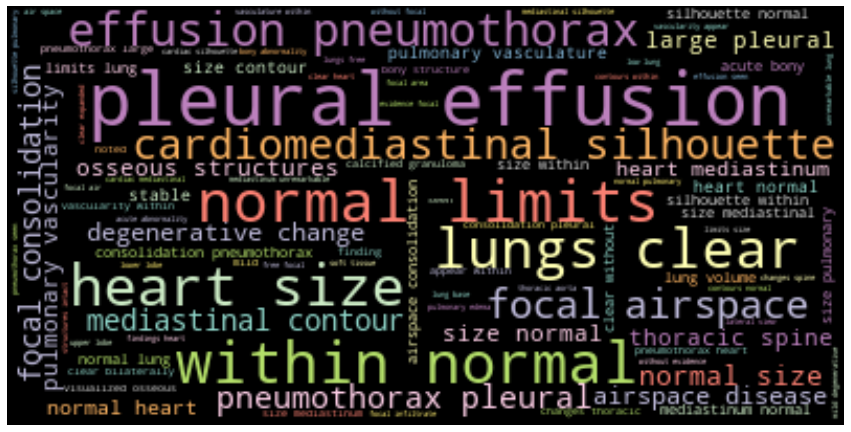

In [ ]:

wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(report_df['findings'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

From wordcloud : pleural, effusion, silhouette, within, normal, lungs, cardiomediastinal are important words.

## Analysis of Uniqueness in IMPRESSION Features

no. of unique impression report in the dataset:1674
No. of impression report repeated more than one times:118



<BarContainer object of 1 artists>

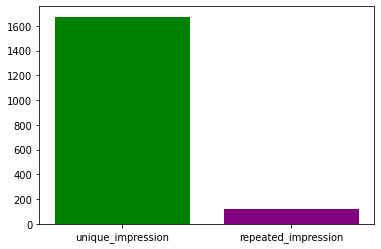

In [35]:
impression_reports=pd.Series(report_df["impression"].tolist())
len_impression=len(impression_reports)
unique_impression_report=len(np.unique(impression_reports))
print("no. of unique impression report in the dataset:{}".format(unique_impression_report))
repeated_impression_report=np.sum(impression_reports.value_counts()>1)
print("No. of impression report repeated more than one times:{}".format(repeated_impression_report))
print()
plt.bar(["unique_impression"], unique_impression_report, color='green')
plt.bar(["repeated_impression"], repeated_impression_report, color='purple' )

We conclude from above impressions features bar plot, total 1674 are repeated impressions sentences in impressions feature and total 118 impressions sentences are unique impressions sentences in the dataset.

## Plotting top 50 frequent sentences of IMPRESSION feature

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


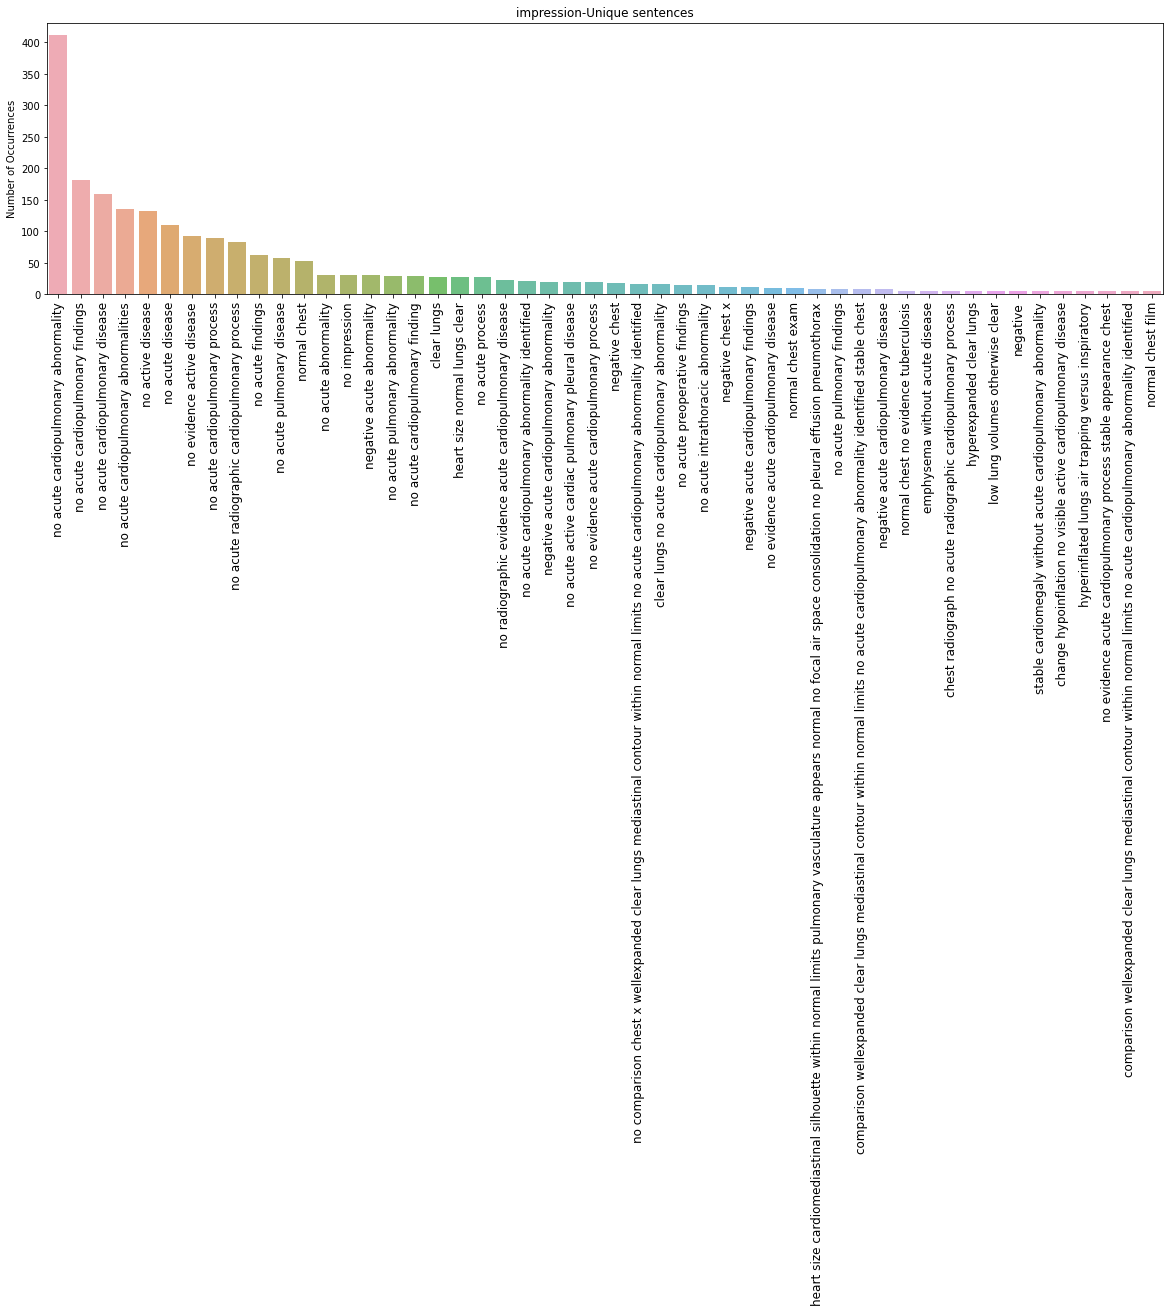

In [ ]:
#Plotting top 50 frequent sentences of Indication feature
sentences = report_df['impression'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("impression-Unique sentences")
plt.show()

## WordCloud of IMPRESSION feature

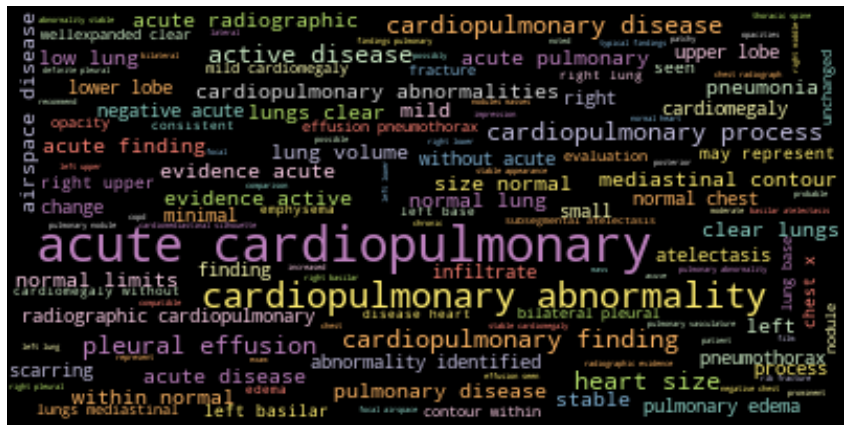

In [ ]:

wordcloud = WordCloud(max_words=400, background_color="black", colormap="Set3").generate(' '.join(report_df['impression'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

From wordcloud : actue cardiopulmonary, cardiopulmonary abnormality, disease acute, heart size  are important words.

## Analysis of Unique/Repeated words in features

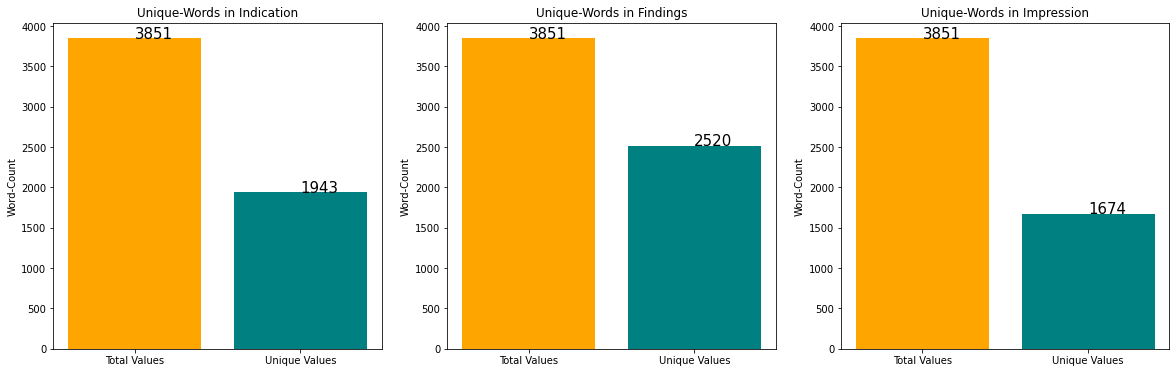

In [32]:
def unique_words_features(df):
    '''This function takes pandas dataframe and show barplot of features unique and repeated words 
       Input  =  pandas dataframe or numpy arrays
       Output =  barplot of the unique words of dataframe '''

    #length of the feature
    len_total = len(df.tolist())

    #length of unique words in the featue
    len_unique = len(np.unique(df.tolist()))

    x = ['Total Values', 'Unique Values']
    y =  [len_total, len_unique]

    plt.bar(x,y,color = ['orange','Teal'])
    plt.ylabel('Word-Count')
    for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
    
    plt.ylabel('Word-Count')

plt.figure(figsize = (20,6))
plt.subplot(131)
unique_words_features(report_df['indication'])
plt.title('Unique-Words in Indication')
plt.subplot(132)
unique_words_features(report_df['findings'])
plt.title('Unique-Words in Findings')
plt.subplot(133)
unique_words_features(report_df['impression'])
plt.title('Unique-Words in Impression')
plt.show()

INDICATIONS : Indication feature has total 1943 unique words in dataset.
FINDINDS : Indication feature has total 2520 unique words in dataset.
IMPRESSION : Indication feature has total 1674 unique words in dataset.

## Plotting PDF and CDF for word_count distribution of Indication feature 

In [ ]:
report_df['indication_count'] = report_df['indication'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
report_df['findings_count'] = report_df['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
report_df['impression_count'] = report_df['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
report_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,indication_count,findings_count,impression_count
0,1,normal,normal,xray chest pa lateral,positive tb test,none,cardiac silhouette mediastinum size within nor...,normal chest x,3,19,3
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,chest views frontal lateral,preop bariatric surgery,none,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings,3,10,4
2,3,normal,normal,xray chest pa lateral,rib pain steps pain r back r elbow r rib no pr...,no comparison,no findings,no displaced rib fractures pneumothorax pleura...,19,2,21
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...",pa lateral views chest hours,,none available,diffuse bilateral interstitial alveolar opacit...,bullous emphysema interstitial fibrosis probab...,0,40,33
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,xray chest pa lateral,chest nasal congestion,no comparison,cardiomediastinal silhouette pulmonary vascula...,no acute cardiopulmonary abnormality,3,29,4


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


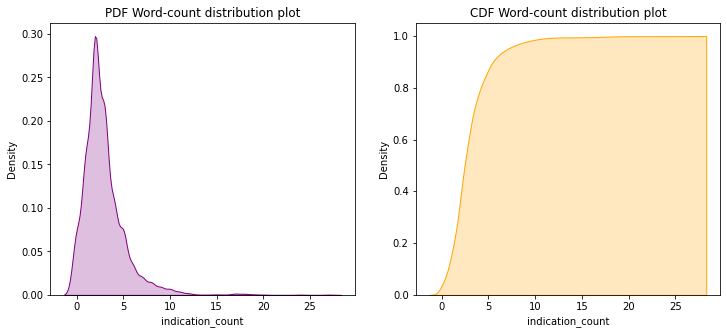

In [ ]:
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(report_df['indication_count'],shade=True,color='purple')
plt.title("PDF Word-count distribution plot")
plt.subplot(122)
# Seaborn CDF
sns.distplot(report_df['indication_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='orange')
plt.title("CDF Word-count distribution plot")
plt.show()

Figure 1: According to the plot above, more than 40% of words have a length of 2-5, whereas 5% have a length of 5-10. Only a few words are longer than 12 words.

Figure 2: As seen in the plot above, 50% of the data in the indicator feature contain 7-8 words, while 99% of the text data have less than 10 words in each row. Only 1% of the data have a length greater than ten.

## Plotting PDF and CDF for word_count distribution of FINDINGS feature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


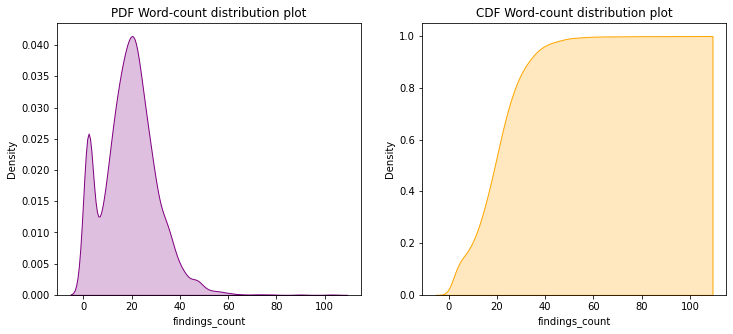

In [ ]:
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(report_df['findings_count'],shade=True,color='purple')
plt.title("PDF Word-count distribution plot")
plt.subplot(122)
# Seaborn CDF
sns.distplot(report_df['findings_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='orange')
plt.title("CDF Word-count distribution plot")
plt.show()

Figure 1: 90% of data lengths range between 5 and 40 words per finding. Some information is more dense in 2-10 words, 10-30 words in length content density exceeds 0.025, and a few words exceed 80 words, according to the research.

Figure 2 : shows that certain findings exceed 80 words per finding. 50% of the data has fewer than 20 words per finding, and 99% of the data has fewer than 48 words each finding.

## Plotting PDF and CDF for word_count distribution of IMPRESSION feature

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


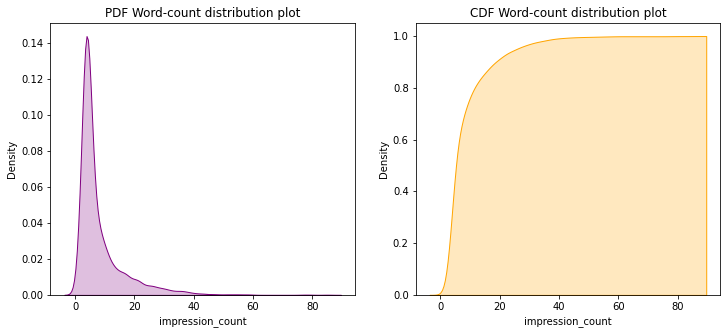

In [ ]:
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(report_df['impression_count'],shade=True,color='purple')
plt.title("PDF Word-count distribution plot")
plt.subplot(122)
# Seaborn CDF
sns.distplot(report_df['impression_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='orange')
plt.title("CDF Word-count distribution plot")
plt.show()

Figure 1: Based on the above plot, we can conclude that 50% of the text data length is between 2-15 and 90% of the data length is between 2-20. More occurrence of 2-10 word length in impression feature.

Figure 2: In 99% of cases, the number of words per impression is less than 39.Only a few impressions have fewer words than 50% of the data, implying that only a few impressions have fewer words.



## Word Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of words')

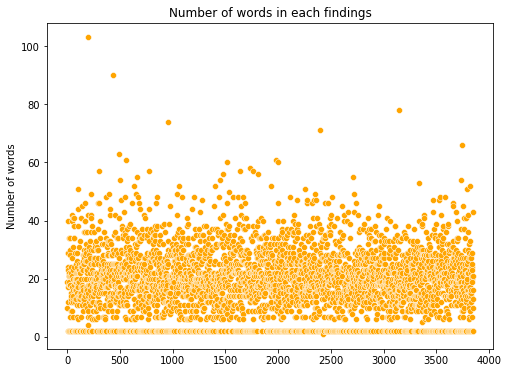

In [ ]:
plt.figure(figsize = (8,6))
l = [len(e.split()) for e in report_df['findings'].values]
plt.title('Number of words in each findings')
sns.scatterplot(range(report_df.shape[0]),l, color='orange')
plt.ylabel('Number of words')


Findings contains less than 60 words. 102 is the maximum word count.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of words')

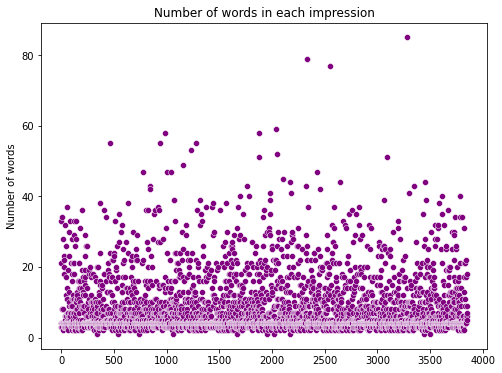

In [ ]:
plt.figure(figsize = (8,6))
l = [len(e.split()) for e in report_df['impression'].values]
plt.title('Number of words in each impression')
sns.scatterplot(range(report_df.shape[0]),l, color='purple')
plt.ylabel('Number of words')




Impression contains less than 60 words. 90 is the maximum word count.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of words')

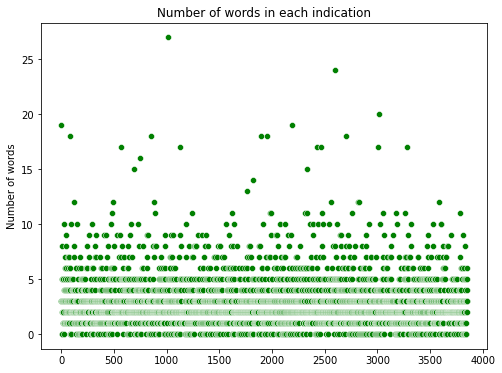

In [ ]:
plt.figure(figsize = (8,6))
l = [len(e.split()) for e in report_df['indication'].values]
plt.title('Number of words in each indication')
sns.scatterplot(range(report_df.shape[0]),l, color='green')
plt.ylabel('Number of words')

Indication contains less than 20 words. 28 is the maximum word count.